### Table of Contents
* [1 PREPROCESSING](#chapter1)
    * [1.1 Describe](#section_1_1)
    * [1.2 Handle missing values](#section_1_2)
    * [1.4 Split](#section_1_3)
* [2 TRAINING](#chapter2)
    * [2.1 Variables](#section_2_1)
    * [2.2 Functions](#section_2_2)
    * [2.3 Training](#section_2_3)
* [3 RESULTS](#chapter3)

______________
Importing necessary libraries and dataset

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler
from models import UnbalancedBagger, UnbalancedBaggerNoSampling
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from statsmodels.stats.contingency_tables import mcnemar
import operator
from sklearn.metrics import precision_score

RANDOM_SEED = 12345

In [40]:
original_df = pd.read_csv("datasets/diabetes.csv")

# PREPROCESSING <a class="anchor" id="chapter1"></a>

## Describe <a class="anchor" id="section_1_1"></a>
* Understand dataset by looking at feature set
* Show class imbalance

In [41]:
original_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


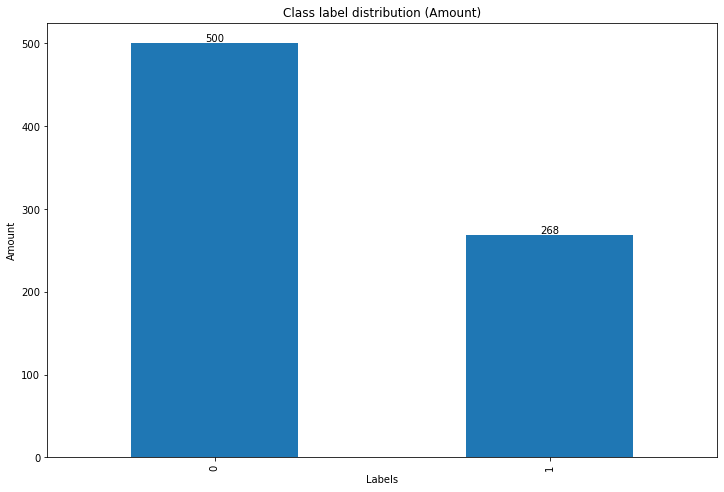

In [42]:
total_labels = original_df.Outcome.value_counts()
x_labels = [0,1]

plt.figure(figsize=(12,8))
ax = total_labels.plot(kind='bar')
ax.set_title('Class label distribution (Amount)')
ax.set_xlabel('Labels')
ax.set_ylabel('Amount')
ax.set_xticklabels(x_labels)

rects = ax.patches

for rect,lbl in zip(rects, total_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height
            , lbl, ha='center', va='bottom')

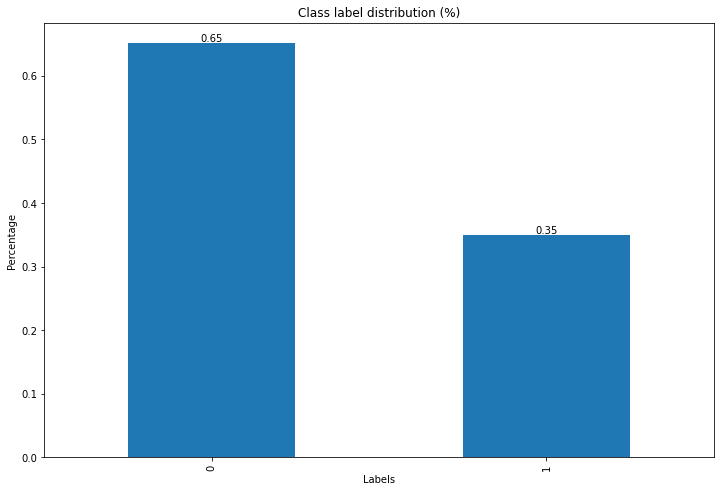

In [43]:
x_labels = [0,1]
total_labels_percentage = original_df.Outcome.value_counts()/len(original_df)

plt.figure(figsize=(12,8))
ax = total_labels_percentage.plot(kind='bar')
ax.set_title('Class label distribution (%)')
ax.set_xlabel('Labels')
ax.set_ylabel('Percentage')
ax.set_xticklabels(x_labels)

rects = ax.patches
labels = []

for lbl in total_labels_percentage:
    labels.append("{0:.2f}".format(lbl))

for rect,lbl in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height
            , lbl, ha='center', va='bottom')

## Handle missing values <a class="anchor" id="section_1_2"></a>
* Find missing values
* Imputate

In [44]:
print("Amount of 0 values:")
print("Glucose: ", len(original_df[original_df["Glucose"] == 0]))
print("BloodPressure: ", len(original_df[original_df["BloodPressure"] == 0]))
print("SkinThickness: ", len(original_df[original_df["SkinThickness"] == 0]))
print("Insulin: ", len(original_df[original_df["Insulin"] == 0]))
print("BMI: ", len(original_df[original_df["BMI"] == 0]))

Amount of 0 values:
Glucose:  5
BloodPressure:  35
SkinThickness:  227
Insulin:  374
BMI:  11


In [45]:
def imputation(data, columns):
    """
    Imputates input data with mean values of corresponding columns.

    Keyword arguments:
    data -- Dataset to impute.
    columns -- Which columns to compute.

    returns imputed dataset
    """
    for c in columns:
         if c in data.columns:
             data[c].replace(0, np.nan,inplace=True)
             data[c].fillna(data[c].mean(), inplace=True)
    return data

In [46]:
original_df = imputation(original_df, ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"])

original_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Split <a class="anchor" id="section_1_3"></a>
* Split dataset into examples and labels.
* Standardize examples for SVC models
* train_test_split for future model training, keeping class imbalance

In [47]:
#we can now split attributes and class label
X = original_df.drop('Outcome', axis=1)
y = original_df.Outcome

X.describe()

#data_standardized used for SVC
scaler = StandardScaler()
data_standardized = scaler.fit_transform(X)
data_standardized = pd.DataFrame(data_standardized,columns=X.columns)

In [48]:
X_train,X_test,y_train,y_test, = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

#standardized split for SVC
X_train_svc,X_test_svc,y_train_svc,y_test_svc, = train_test_split(data_standardized, y, test_size=0.3, random_state=RANDOM_SEED,stratify=y)

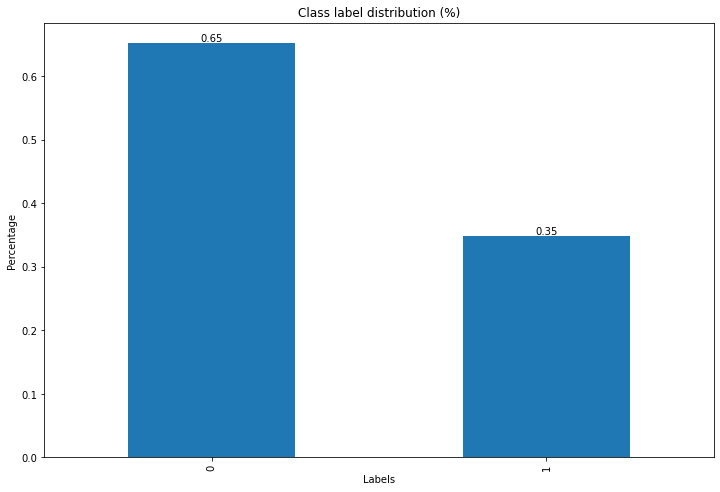

In [49]:
x_labels = [0,1]
total_labels_percentage = y_train.value_counts()/len(y_train)

plt.figure(figsize=(12,8))
ax = total_labels_percentage.plot(kind='bar')
ax.set_title('Class label distribution (%)')
ax.set_xlabel('Labels')
ax.set_ylabel('Percentage')
ax.set_xticklabels(x_labels)

rects = ax.patches
labels = []

for lbl in total_labels_percentage:
    labels.append("{0:.2f}".format(lbl))

for rect,lbl in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height
            , lbl, ha='center', va='bottom')

# TRAINING <a class="anchor" id="chapter2"></a>

## Variables <a class="anchor" id="section_2_1"></a>
* Define and declare needed variables

In [50]:
param_grid_svc = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf', 'poly']},
 ]

param_grid_dt = [
    {'splitter' : ['best', 'random'],
     'min_samples_split':[2,5,10],
     'min_samples_leaf':[1,5,10],
     'min_weight_fraction_leaf':[0,0.05, 0.1, 0.15, 0.2]
     }
]

dtc = DecisionTreeClassifier(random_state=RANDOM_SEED)
svc = SVC(random_state=RANDOM_SEED, probability=True)

ros = RandomOverSampler(random_state=RANDOM_SEED)
rus = RandomUnderSampler(random_state=RANDOM_SEED)
smote = SMOTE(random_state=RANDOM_SEED, sampling_strategy='minority')

search_dtc = GridSearchCV(dtc, param_grid_dt, cv=10, scoring='average_precision')
search_svc = GridSearchCV(svc, param_grid_svc, cv=10, scoring='average_precision')

list_of_auprc = []
list_of_avg_prec = []
list_of_mcnemar_results = []
list_of_recall_results = []
list_of_precision_results = []

## Functions <a class="anchor" id="section_2_2"></a>
* Functions needed for training and results.

In [51]:
def smote_technique(X,y):
    """Samples X using SMOTE.

    Keyword arguments:
    X -- Examples of original dataset
    y -- True labels of examples

    Returns:
    Sampled result

    Further reading:
    https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html
    """
    x_sample, y_sample = smote.fit_sample(X, y)
    return x_sample,y_sample

def random_oversampling_technique(X,y):
    """Samples X using Random Oversampling.

    Keyword arguments:
    X -- Examples of original dataset
    y -- True labels of examples

    Returns:
    Sampled result

    Further reading:
    https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.RandomOverSampler.html
    """
    x_sample, y_sample = ros.fit_sample(X, y)
    return x_sample,y_sample

def random_undersampling_technique(X,y):
    """Samples X using Random Undersampling.

    Keyword arguments:
    X -- Examples of original dataset
    y -- True labels of examples

    Returns:
    Sampled result

    Further reading:
    https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html
    """
    x_sample, y_sample = rus.fit_sample(X, y)
    return x_sample,y_sample

In [52]:
def create_AUPRC_curves(list_of_rpl):
    """
    Creates AUPRC curves using Pyplot.

    Keyword arguments:
    list_of_rpl -- List of precision-recall pairs for different probability thresholds on the positive class, for each model.
    """
    #Create subplots on one row and two columns:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    #Set labels on subplot 0:
    axes[0].set(xlabel="recall")
    axes[0].set(ylabel="precision")
    axes[0].set(title="DT")
    #Set labels on subplot 1:
    axes[1].set(xlabel="recall")
    axes[1].set(ylabel="precision")
    axes[1].set(title="SVC")
    #Iterate each curve and plot to either subplot 0 or subplot 1, depending on model used:
    for recall, prec, lbl in list_of_rpl:
        #If lbl contains substring "DT" then that curve belongs to subplot 0:
        if "DT" in lbl:
            axes[0].plot(recall,prec,marker='.', label=lbl)
        #Else a SVC model was used and belongs to subplot 1:
        else:
            axes[1].plot(recall,prec,marker='.', label=lbl)
    #Thighten the figure:
    fig.tight_layout()

In [53]:
def get_AUPRC_values(y_probs, y_true, label):
    """
    Calculate average precision and AUPRC curves.

    Keyword arguments:
    y_probs -- Predicted class probabilites using a model.
    y_true -- True labels.
    label -- Label used to distinguish model from other models.

    Returns:
    (1) Returns AUPRC curve followed by the label parameter as a list.
    (2) Returns average precision score followed by the label parameter as a list.

    Further reading:
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
    """
    pos_probs = y_probs[:,1]
    prec,recall,_ = precision_recall_curve(y_true, pos_probs)
    avg_prec = average_precision_score(y_true, pos_probs)
    return [prec,recall,label], [avg_prec, label]

In [54]:
def calculate_cont_table(model_one_preds, model_two_preds, true_preds):
    """
    Calculate contingency table for McNemar test.

    Keyword arguments:
    model_one_preds -- Predictions of model one.
    model_two_preds -- Predictions of model two.
    true_preds -- True labels.

    Returns:
    Contingency table as: [[both models correct, model one correct], [model two correct, none of the models correct]].
    """
    #Init table variables
    both_correct, model1_correct, model2_correct, non_correct = 0,0,0,0
    #Iterate 0-length of ndarray true_preds
    for idx in range(len(true_preds)):
        #if predicted label of model  one is the same as the true label
        if model_one_preds[idx] == true_preds[idx]:
            #if predicted label of model two is the same as the true label
            if model_two_preds[idx] == true_preds[idx]:
                both_correct = both_correct + 1
            #Only model one predicted the true label
            else:
                model1_correct = model1_correct + 1
        #Else if predicted label of model two is the same as the true label
        elif model_two_preds[idx] == true_preds[idx]:
            model2_correct = model2_correct + 1
        #Else, none of the models predicted the true label
        else:
            non_correct = non_correct + 1
    return [[both_correct,model1_correct],[model2_correct,non_correct]]

In [55]:
def calculate_mcneamar(table):
    """
    Calculate McNemar result using statsmodel mcnemar.

    Keyword arguments:
    table -- Contingency table of two models (See function: calculate_cont_table).

    Returns:
    (1) Statistic's result
    (2) p-value

    Further reading:
    https://www.statsmodels.org/dev/generated/statsmodels.stats.contingency_tables.mcnemar.html
    """
    result = mcnemar(table, exact=False, correction=False)
    return result.statistic, result.pvalue

In [56]:
def get_mcnemar_df():
    """
    Creates and returns a dataframe of McNemar results.

    Returns:
    Dataframe of McNemar results.
    """
    #Create emtpy lists to hold values
    labels = []
    p_values = []
    stats = []
    #Iterate list_of_mcnemar_results containing the McNemar results of each model
    for label, values in list_of_mcnemar_results:
        #Append iter.items to corresponding list
        labels.append(label)
        stats.append(values[0])
        p_values.append(values[1])
    #Create dict of key-value pairs
    data = {'Model':labels, 'Statistic':stats, 'p_value':p_values}
    #Create dataframe using dictionary
    df = pd.DataFrame(data,columns=["Model", "Statistic", "p_value"])
    return df

In [57]:
def get_preds_and_probs(classifier, X_test):
    """
    Gets classifier predictions and predicted probabilites using SKlearn predict(X) and predict_proba(X).

    Keyword arguments:
    classifier -- The classifier to use for predicting and predicting probabilites.
    X_test -- The set of examples to predict.

    Returns:
    Classifier predictions and predicted probabilites.
    """
    preds = classifier.predict(X_test)
    probs = classifier.predict_proba(X_test)
    return preds,probs

In [58]:
def calc_and_add_classifier_results(class_preds, class_probs, y_true, label):
    """
    Calculates recall, precisionand AUPRC and adds them to their corresponding lists.

    Keyword arguments:
    class_preds -- Predicted labels of used model.
    class_probs -- Predicted probabilites of used model.
    y_true -- True labels.
    label -- Label used to distinguish model from other models.

    Further reading:
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
    """
    recall = recall_score(y_true, class_preds, average='binary',pos_label=1)
    list_of_recall_results.append([recall, label])

    precision = precision_score(y_true, class_preds, average='binary',pos_label=1)
    list_of_precision_results.append([precision, label])

    auprc, avg_prec = get_AUPRC_values(class_probs, y_true, label)
    list_of_auprc.append(auprc)
    list_of_avg_prec.append(avg_prec)

In [59]:
def calc_and_add_significance(classifier_one, classifier_two, y_true, label):
    """
    Calculates McNemar significance of two input models and store result in list_of_mcnemar_results.

    Keyword arguments:
    classifier_one -- Prediction results of first classifier used.
    classifier_two -- Prediction results of second classifier used.
    y_true -- True labels.
    label -- Label used to distinguish model from other models.
    """
    table = calculate_cont_table(classifier_one, classifier_two, y_true.values)
    list_of_mcnemar_results.append([label, calculate_mcneamar(table)])

In [60]:
def split_SVC_DT(list):
    """
    Split input list depending on substring 'DT' and 'SVC'.

    Keyword arguments:
    list -- Input list to split.

    Returns:
    (1) A list containing the DT models.
    (2) A list containing the SVC models.
    """
    #Creates empty list of DT and SVC models.
    DT_list = []
    SVC_list = []
    #Iterate input list values
    for score,item in list:
        #If sub-item contains substring 'DT' then belongs to DT_list, which contains the DT models
        if 'DT' in item:
            DT_list.append([score,item])
        #Else belongs to SVC_list, which contains the SVC models
        else:
            SVC_list.append([score,item])
    return DT_list, SVC_list

In [61]:
def sort(list):
    """
    Sorts input-list according to value of item on index 0 per sub-item.

    Keyword arguments:
    list -- Input list to sort.

    Returns:
    A sorted list of the original list.
    """
    sorted_list = sorted(list, key=operator.itemgetter(0), reverse=True)
    return sorted_list

In [62]:
def create_bars(list, title):
    """
    Creates a barh which correspond to input-list.

    Keyword arguments:
    list -- Input list to plot.
    title -- Title for the barh.

    Further reading:
    https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.barh.html
    """
    #unzip sub-items to list of labels and list of values.
    y,x = zip(*list)
    #create new figure of figsize=12,8
    plt.figure(figsize=(12,8))
    #plot barh with x,y values
    plt.barh(x, y)
    #plot title
    plt.title(title)
    #Iterate values and plot them next to corresponding bar
    for index, value in enumerate(y):
        plt.text(value, index, str("{0:.2f}".format(value)))

In [63]:
def plot_bars(list, label):
    """
    Splits, sorts and creates barh plots of input-list.

    Keyword arguments:
    list -- List to split, sort and plot.
    label -- Title of barh.
    """
    #split input-list to dt_models and svc_models
    dt_models, svc_models = split_SVC_DT(list)
    #sort the new lists
    sorted_dt = sort(dt_models)
    sorted_svc = sort(svc_models)
    #plot bars of the lists
    create_bars(sorted_dt, label + ", DT")
    create_bars(sorted_svc, label + ", SVC")

## Training <a class="anchor" id="section_2_3"></a>
* Train models and store results.

In [64]:
#unbalanced bagging, using smote, ros, rus
sampling_techniques = [smote, ros, rus]
svc = SVC(C=1000, gamma=0.001, random_state=12345, probability=True)
dtc = DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,random_state=12345)

dt_predict, dt_proba = UnbalancedBagger.unbalanced_bagger(X_train, y_train, 10, sampling_techniques,base_estimator=dtc,random_seed=RANDOM_SEED)
svc_predict, svc_proba = UnbalancedBagger.unbalanced_bagger(X_train_svc, y_train_svc, 10, sampling_techniques,base_estimator=svc,random_seed=RANDOM_SEED)

predictions_dt_unb = dt_predict(X_test)
dt_probs_preds = dt_proba(X_test)
predictions_svc_unb = svc_predict(X_test_svc)
svc_probs_preds = svc_proba(X_test_svc)

calc_and_add_classifier_results(predictions_dt_unb, dt_probs_preds, y_test, "Unb_bagging, DT")
calc_and_add_classifier_results(predictions_svc_unb, svc_probs_preds, y_test_svc, "Unb_bagging, SVC")

In [65]:
#Train on original data
dt_classifier = search_dtc.fit(X_train, y_train).best_estimator_
svc_classifier = search_svc.fit(X_train_svc, y_train_svc).best_estimator_

dt_predictions, dt_probs_preds = get_preds_and_probs(dt_classifier, X_test)
svc_predictions, svc_probs_preds = get_preds_and_probs(svc_classifier, X_test_svc)

calc_and_add_classifier_results(dt_predictions, dt_probs_preds, y_test, "Original, DT")
calc_and_add_classifier_results(svc_predictions, svc_probs_preds, y_test_svc, "Original, SVC")

calc_and_add_significance(predictions_dt_unb,dt_predictions, y_test, "Original, DT")
calc_and_add_significance(predictions_svc_unb,svc_predictions, y_test_svc, "Original, SVC")

print("Best DT estimator: ", search_dtc.best_estimator_)
print("Best SVC estimator: ", search_svc.best_estimator_)

Best DT estimator:  DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,
                       random_state=12345, splitter='random')
Best SVC estimator:  SVC(C=1000, gamma=0.001, probability=True, random_state=12345)


In [66]:
#Train on SMOTE
sampled_dtc_x, sampled_dtc_y = smote_technique(X_train,y_train)
sampled_svc_x, sampled_svc_y = smote_technique(X_train_svc,y_train_svc)

dt_classifier = search_dtc.fit(sampled_dtc_x, sampled_dtc_y).best_estimator_
svc_classifier = search_svc.fit(sampled_svc_x, sampled_svc_y).best_estimator_

dt_predictions, dt_probs_preds = get_preds_and_probs(dt_classifier, X_test)
svc_predictions, svc_probs_preds = get_preds_and_probs(svc_classifier, X_test_svc)

calc_and_add_classifier_results(dt_predictions, dt_probs_preds, y_test, "SMOTE, DT")
calc_and_add_classifier_results(svc_predictions, svc_probs_preds, y_test_svc, "SMOTE, SVC")

calc_and_add_significance(predictions_dt_unb,dt_predictions, y_test, "SMOTE, DT")
calc_and_add_significance(predictions_svc_unb,svc_predictions, y_test_svc, "SMOTE, SVC")

print("Best DT estimator: ", search_dtc.best_estimator_)
print("Best SVC estimator: ", search_svc.best_estimator_)

Best DT estimator:  DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,
                       random_state=12345, splitter='random')
Best SVC estimator:  SVC(C=1000, gamma=0.001, probability=True, random_state=12345)


In [67]:
#Train on random oversampling
sampled_dtc_x, sampled_dtc_y = random_oversampling_technique(X_train,y_train)
sampled_svc_x, sampled_svc_y = random_oversampling_technique(X_train_svc,y_train_svc)

dt_classifier = search_dtc.fit(sampled_dtc_x, sampled_dtc_y)
svc_classifier = search_svc.fit(sampled_svc_x, sampled_svc_y)

dt_predictions, dt_probs_preds = get_preds_and_probs(dt_classifier, X_test)
svc_predictions, svc_probs_preds = get_preds_and_probs(svc_classifier, X_test_svc)

calc_and_add_classifier_results(dt_predictions, dt_probs_preds, y_test, "Rand_Over, DT")
calc_and_add_classifier_results(svc_predictions, svc_probs_preds, y_test_svc, "Rand_Over, SVC")

calc_and_add_significance(predictions_dt_unb,dt_predictions, y_test, "Rand_Over, DT")
calc_and_add_significance(predictions_svc_unb,svc_predictions, y_test_svc, "Rand_Over, SVC")

print("Best DT estimator: ", search_dtc.best_estimator_)
print("Best SVC estimator: ", search_svc.best_estimator_)

Best DT estimator:  DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,
                       random_state=12345)
Best SVC estimator:  SVC(C=1000, gamma=0.001, probability=True, random_state=12345)


In [68]:
#Train on random undersampling
sampled_dtc_x, sampled_dtc_y = random_undersampling_technique(X_train,y_train)
sampled_svc_x, sampled_svc_y = random_undersampling_technique(X_train_svc,y_train_svc)

dt_classifier = search_dtc.fit(sampled_dtc_x, sampled_dtc_y)
svc_classifier = search_svc.fit(sampled_svc_x, sampled_svc_y)

dt_predictions, dt_probs_preds = get_preds_and_probs(dt_classifier, X_test)
svc_predictions, svc_probs_preds = get_preds_and_probs(svc_classifier, X_test_svc)

calc_and_add_classifier_results(dt_predictions, dt_probs_preds, y_test, "Rand_Under, DT")
calc_and_add_classifier_results(svc_predictions, svc_probs_preds, y_test_svc, "Rand_Under, SVC")

calc_and_add_significance(predictions_dt_unb,dt_predictions, y_test, "Rand_Under, DT")
calc_and_add_significance(predictions_svc_unb,svc_predictions, y_test_svc, "Rand_Under, SVC")

print("Best DT estimator: ", search_dtc.best_estimator_)
print("Best SVC estimator: ", search_svc.best_estimator_)

Best DT estimator:  DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,
                       random_state=12345)
Best SVC estimator:  SVC(C=1000, gamma=0.001, probability=True, random_state=12345)


In [69]:
#BAGGINBG
svc = SVC(C=1000, gamma=0.001, random_state=12345, probability=True)
dtc = DecisionTreeClassifier(min_samples_leaf=10, min_weight_fraction_leaf=0,splitter='random',random_state=12345)

dt_predict, dt_proba = UnbalancedBaggerNoSampling.unbalanced_bagger_no_sampling(X_train, y_train, 10,random_seed=RANDOM_SEED)
svc_predict, svc_proba = UnbalancedBaggerNoSampling.unbalanced_bagger_no_sampling(X_train_svc, y_train_svc, 10,random_seed=RANDOM_SEED)

dt_predictions = dt_predict(X_test)
dt_probs_preds = dt_proba(X_test)
svc_predictions = svc_predict(X_test_svc)
svc_probs_preds = svc_proba(X_test_svc)

calc_and_add_classifier_results(dt_predictions, dt_probs_preds, y_test, "Bagging, DT")
calc_and_add_classifier_results(svc_predictions, svc_probs_preds, y_test_svc, "Bagging, SVC")

calc_and_add_significance(predictions_dt_unb,dt_predictions, y_test, "Bagging, DT")
calc_and_add_significance(predictions_svc_unb,svc_predictions, y_test_svc, "Bagging, SVC")

# RESULTS <a class="anchor" id="chapter3"></a>
* Plot results

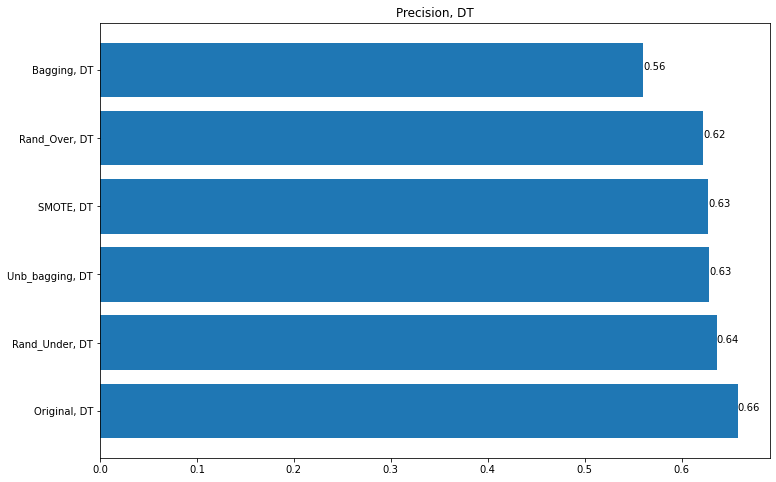

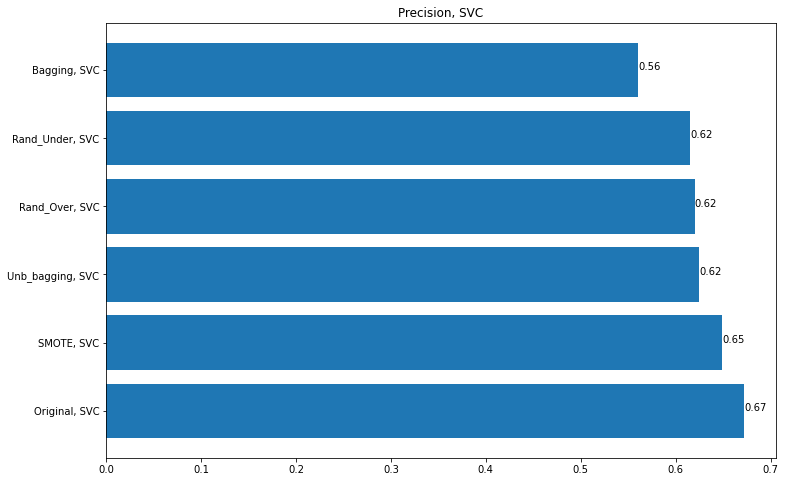

In [70]:
plot_bars(list_of_precision_results, "Precision")
plt.show()

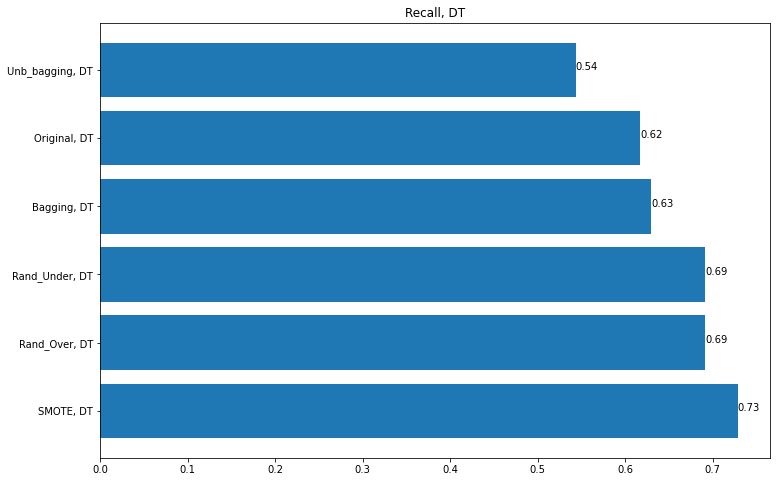

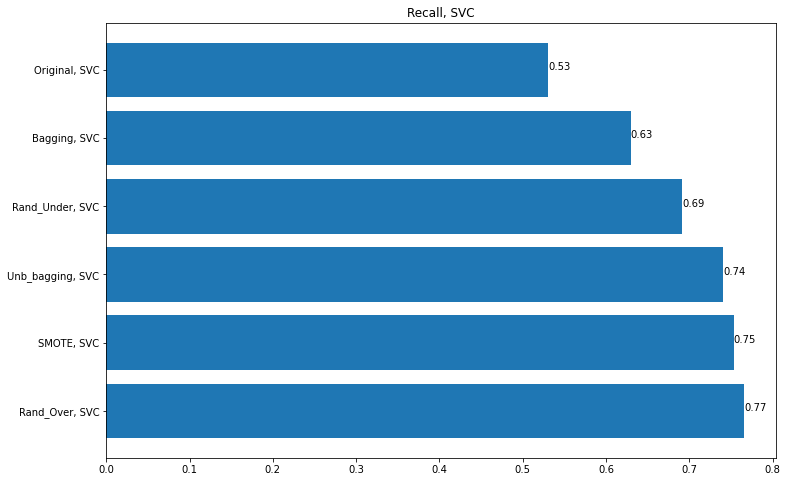

In [71]:
plot_bars(list_of_recall_results, "Recall")
plt.show()

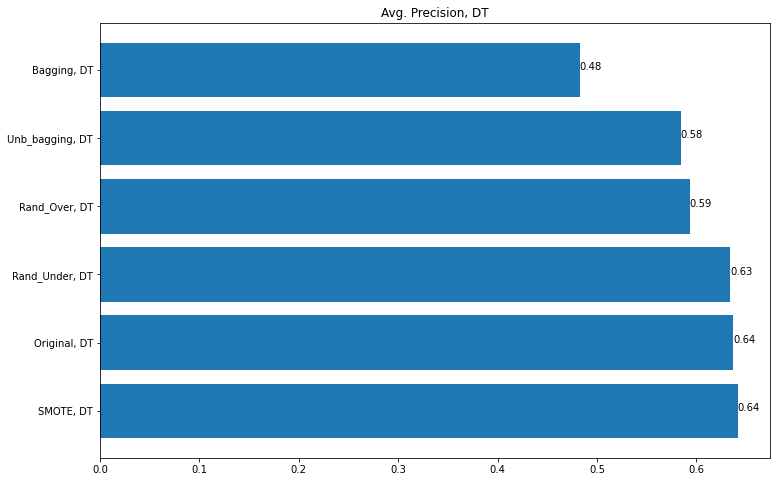

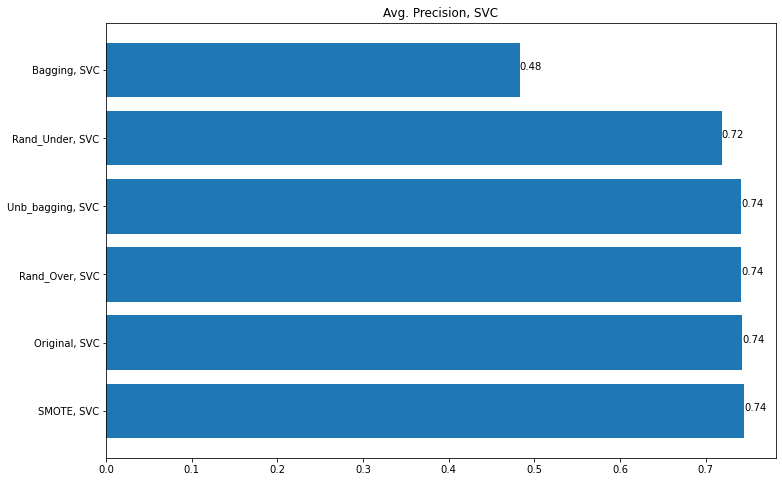

In [72]:
plot_bars(list_of_avg_prec, "Avg. Precision")
plt.show()

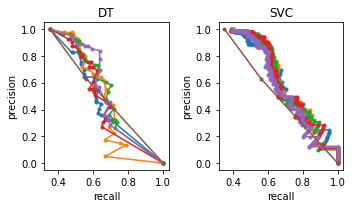

In [73]:
create_AUPRC_curves(list_of_auprc)
plt.show()

In [74]:
print(get_mcnemar_df())

             Model  Statistic   p_value
0     Original, DT   0.720000  0.396144
1    Original, SVC   0.100000  0.751830
2        SMOTE, DT   0.473684  0.491297
3       SMOTE, SVC   0.571429  0.449692
4    Rand_Over, DT   0.320000  0.571608
5   Rand_Over, SVC   0.000000  1.000000
6   Rand_Under, DT   0.642857  0.422678
7  Rand_Under, SVC   0.272727  0.601508
8      Bagging, DT   0.753846  0.385261
9     Bagging, SVC   2.522388  0.112240
